# Deep Learning Model with Hyperparameter Tuning

### ImageNet Models:
- MobileNetV3 Small
- MobileNetV3 Large
- NASNetMobile
- EfficientNetV2 B0
- DenseNet121
- ResNet50
- ResNet50V2
- InceptionV3
- Xception
- InceptionResNetV2
- VGG16

##### pip install keras-tuner

In [2]:
## Imports
import os
import shutil
import uuid
import cv2
import warnings
import keras
import time
import numpy as np
import pandas as pd
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns

## Tensorflow Imports
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large, NASNetMobile, EfficientNetB0, EfficientNetV2B0, ConvNeXtTiny, DenseNet121, ResNet50V2, ConvNeXtSmall, ConvNeXtSmall, ConvNeXtBase, InceptionV3, Xception, InceptionResNetV2, VGG16 
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Input
from tensorflow.keras import backend as K

## Sklearn Imports
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, classification_report, precision_recall_curve, ConfusionMatrixDisplay

warnings.filterwarnings("ignore")

In [3]:
#Try with 2000 samples from each class

X = []
y = []
classes = ['no_pathology_train', 'pathology_train']
base_path = 'C:/Users/vella/Mastes Thesis/processed_data/'

#Turn images into numpy arrays
for i, target in enumerate(classes):
    files = base_path+target+'/'
    
    for file in os.listdir(files):
        
        # load the image
        img = image.load_img(files+file)
        
        # convert it to an array
        img_array = image.img_to_array(img, dtype='uint8')
        
        # resize 
        img_array = cv2.resize(img_array, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        
        # append the array to X
        X.append(img_array)
        
        # append the target to y
        y.append(target)


X = np.array(X)
y = np.array(y)

y_dict = {'no_pathology_train':0, 'pathology_train':1}
y = np.vectorize(y_dict.get)(y)

# shuffle the data
shuffler = np.random.permutation(len(X))
X = X[shuffler]
y = y[shuffler]

X.shape, y.shape
# y

((25682, 224, 224, 3), (25682,))

In [4]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
# X_train.shape,y_train.shape,X_test.shape,y_test.shape

# convert to binary
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train.shape, y_test.shape

X_train.shape,y_train.shape,X_test.shape,y_test.shape

((20545, 224, 224, 3), (20545, 2), (5137, 224, 224, 3), (5137, 2))

In [5]:
# For results
model_results = pd.DataFrame({'Metrics':['Accuracy', 'Precision', 'Recall', 'F1Score', 'ROC AUC']})
model_results.head()

,Metrics
0,Accuracy
1,Precision
2,Recall
3,F1Score
4,ROC AUC


In [6]:
## evaluation functions 

def evaluate(ytest, ypred, xtrain, ytrain):
    
    accuracy = accuracy_score(ytest, ypred)
    precision = precision_score(ytest, ypred)
    recall = recall_score(ytest, ypred)
    f1score = f1_score(ytest, ypred)
    auc = roc_auc_score(ytest, ypred)
    conf_matrix = confusion_matrix(ytest, ypred)
    
    print("\n--------------- Evaluation ---------------")
    print(f'Accuracy: {accuracy:.3}')
    print(f'Precision: {precision:.3}')
    print(f'Recall: {recall:.3}')
    print(f'F1 Score: {f1score:.3}')
    print(f'ROC AUC: {auc:.3}')
    print(f'\nClassification Report: ')
    print(classification_report(ytest, ypred, target_names=['0 -  Negative (No Pathology)', '1 - Positive (Pathology)']))
    #print(f'\nConfusion Matrix: \n {conf_matrix}')
    print("\n--------------- Visual Evaluation ---------------")
    disp = ConfusionMatrixDisplay.from_predictions(ytest, ypred, cmap = 'cool')
    #disp.plot()
    fig = disp.figure_
    fig.set_figwidth(14)
    fig.set_figheight(5) 
    fig.suptitle('Confusion Matrix', fontsize = 15)
    plt.show()
        
    return accuracy, precision, recall, f1score, auc

In [7]:
def plot_curves(model_title, history):
    # Curve plots
    plt.figure(figsize=(12, 6))

    # Accuracy curve plot
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')  
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss curve plot
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')  
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()


    # Main title for the entire figure
    plt.suptitle(f"{model_title} Accuracy and Loss Curve Plot", fontsize=16)
    
    # Show the plots
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  
    plt.show()

In [8]:
classes = ['no_pathology_train', 'pathology_train']  # Update this based on your dataset


def build_model(hp, model_name):  # Hyperparameter object
    K.clear_session()

    # Load Pretrained Base Model
    init_model = model_name(include_top=False, weights="imagenet", pooling='avg',
                                  input_tensor=Input(shape=(224, 224, 3)))

    # Freeze Pretrained Weights
    init_model.trainable = False

    # Define Model
    model = Sequential()
    model.add(init_model)

    # **Tune the number of neurons in the Dense layer**
    units = hp.Int('units', min_value=64, max_value=256, step=64)
    model.add(Dense(units, activation='relu'))

    # **Tune the dropout rate**
    dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    model.add(Dropout(dropout))

    model.add(Dense(len(classes), activation='softmax'))

    # **Tune the learning rate and optimizer**
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    learning_rate = hp.Choice('lr', [0.0001, 0.001, 0.01])

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    # Compile Model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


## MobileNetV3 Small 

In [9]:
# Define Tuner
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, MobileNetV3Small),
    objective='val_accuracy',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times each model is trained
    directory='tuning_results',  
    project_name='hyperparameter_tuning'
)

# Stop early if no improvement in 3 epochs
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Start Hyperparameter Search
tuner.search(X_train, y_train, epochs=10, validation_split=0.3, callbacks=[callback])

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: units={best_hps.get('units')}, dropout={best_hps.get('dropout')}, "
      f"optimizer={best_hps.get('optimizer')}, learning rate={best_hps.get('lr')}")

Reloading Tuner from tuning_results\hyperparameter_tuning\tuner0.json
Best Hyperparameters: units=64, dropout=0.2, optimizer=adam, learning rate=0.001


Epoch 1/20
450/450 [==============================] - 116s 252ms/step - loss: 0.1747 - accuracy: 0.9305 - val_loss: 0.0557 - val_accuracy: 0.9860
Epoch 2/20
450/450 [==============================] - 101s 226ms/step - loss: 0.0459 - accuracy: 0.9876 - val_loss: 0.0232 - val_accuracy: 0.9959
Epoch 3/20
450/450 [==============================] - 111s 246ms/step - loss: 0.0268 - accuracy: 0.9930 - val_loss: 0.0326 - val_accuracy: 0.9917
Epoch 4/20
450/450 [==============================] - 100s 223ms/step - loss: 0.0142 - accuracy: 0.9964 - val_loss: 0.0123 - val_accuracy: 0.9974
Epoch 5/20
450/450 [==============================] - 99s 221ms/step - loss: 0.0109 - accuracy: 0.9976 - val_loss: 0.0118 - val_accuracy: 0.9971
Epoch 6/20
450/450 [==============================] - 102s 226ms/step - loss: 0.0077 - accuracy: 0.9983 - val_loss: 0.0143 - val_accuracy: 0.9966
Epoch 7/20
450/450 [==============================] - 100s 223ms/step - loss: 0.0071 - accuracy: 0.9981 - val_loss: 0.0211 - 

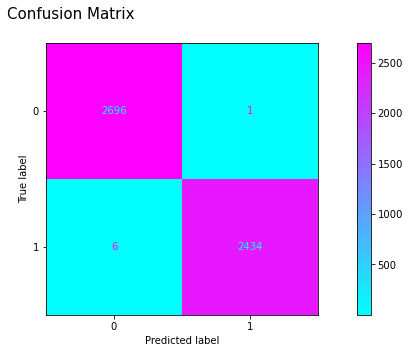

In [10]:
# Build Model with Best Hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train Model
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.3, callbacks=[callback])

# Evaluate Model on Test Data
pred = best_model.predict(X_test)
y_pred = np.argmax(pred, axis=1)
y_test = np.argmax(y_test, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['MobileNetV3 Small Tuned'] = results

## MobileNetV3 Large 

In [11]:
# Define Tuner
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, MobileNetV3Large),
    objective='val_accuracy',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times each model is trained
    directory='tuning_results',  
    project_name='hyperparameter_tuning'
)

# Stop early if no improvement in 3 epochs
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Start Hyperparameter Search
tuner.search(X_train, y_train, epochs=10, validation_split=0.3, callbacks=[callback])

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: units={best_hps.get('units')}, dropout={best_hps.get('dropout')}, "
      f"optimizer={best_hps.get('optimizer')}, learning rate={best_hps.get('lr')}")

Reloading Tuner from tuning_results\hyperparameter_tuning\tuner0.json
Best Hyperparameters: units=64, dropout=0.2, optimizer=adam, learning rate=0.001


In [14]:
# Build Model with Best Hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train Model
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.3, callbacks=[callback])

# Evaluate Model on Test Data
pred = best_model.predict(X_test)
y_pred = np.argmax(pred, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['MobileNetV3 Large Tuned'] = results

Epoch 1/20
450/450 [==============================] - 242s 531ms/step - loss: 0.1315 - accuracy: 0.9518 - val_loss: 0.0277 - val_accuracy: 0.9948
Epoch 2/20
450/450 [==============================] - 226s 503ms/step - loss: 0.0248 - accuracy: 0.9943 - val_loss: 0.0164 - val_accuracy: 0.9959
Epoch 3/20
450/450 [==============================] - 227s 505ms/step - loss: 0.0134 - accuracy: 0.9971 - val_loss: 0.0106 - val_accuracy: 0.9981
Epoch 4/20
450/450 [==============================] - 231s 513ms/step - loss: 0.0082 - accuracy: 0.9983 - val_loss: 0.0081 - val_accuracy: 0.9984
Epoch 5/20
450/450 [==============================] - 235s 523ms/step - loss: 0.0061 - accuracy: 0.9983 - val_loss: 0.0119 - val_accuracy: 0.9971
Epoch 6/20
450/450 [==============================] - 231s 513ms/step - loss: 0.0047 - accuracy: 0.9990 - val_loss: 0.0093 - val_accuracy: 0.9979
Epoch 7/20
450/450 [==============================] - 235s 524ms/step - loss: 0.0048 - accuracy: 0.9989 - val_loss: 0.0079 -

AxisError: axis 1 is out of bounds for array of dimension 1


--------------- Evaluation ---------------
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0

Classification Report: 
                              precision    recall  f1-score   support

0 -  Negative (No Pathology)       1.00      1.00      1.00      2697
    1 - Positive (Pathology)       1.00      1.00      1.00      2440

                    accuracy                           1.00      5137
                   macro avg       1.00      1.00      1.00      5137
                weighted avg       1.00      1.00      1.00      5137


--------------- Visual Evaluation ---------------


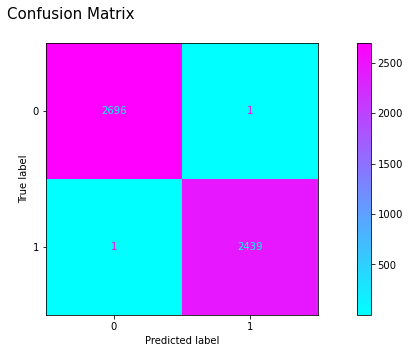

In [15]:
results = evaluate(y_test, y_pred, X_train, y_train)
model_results['MobileNetV3 Large Tuned'] = results

##  NASNetMobile

In [16]:
# Define Tuner
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, NASNetMobile),
    objective='val_accuracy',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times each model is trained
    directory='tuning_results',  
    project_name='hyperparameter_tuning'
)

# Stop early if no improvement in 3 epochs
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Start Hyperparameter Search
tuner.search(X_train, y_train, epochs=10, validation_split=0.3, callbacks=[callback])

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: units={best_hps.get('units')}, dropout={best_hps.get('dropout')}, "
      f"optimizer={best_hps.get('optimizer')}, learning rate={best_hps.get('lr')}")

Reloading Tuner from tuning_results\hyperparameter_tuning\tuner0.json
Best Hyperparameters: units=64, dropout=0.2, optimizer=adam, learning rate=0.001


Epoch 1/20
450/450 [==============================] - 327s 707ms/step - loss: 0.6798 - accuracy: 0.7469 - val_loss: 0.3356 - val_accuracy: 0.8537
Epoch 2/20
450/450 [==============================] - 313s 697ms/step - loss: 0.2996 - accuracy: 0.8775 - val_loss: 0.2929 - val_accuracy: 0.8725
Epoch 3/20
450/450 [==============================] - 315s 701ms/step - loss: 0.2326 - accuracy: 0.9075 - val_loss: 0.1852 - val_accuracy: 0.9401
Epoch 4/20
450/450 [==============================] - 315s 702ms/step - loss: 0.1924 - accuracy: 0.9266 - val_loss: 0.1789 - val_accuracy: 0.9379
Epoch 5/20
450/450 [==============================] - 315s 700ms/step - loss: 0.1630 - accuracy: 0.9410 - val_loss: 0.1623 - val_accuracy: 0.9460
Epoch 6/20
450/450 [==============================] - 314s 698ms/step - loss: 0.1468 - accuracy: 0.9444 - val_loss: 0.1469 - val_accuracy: 0.9458
Epoch 7/20
450/450 [==============================] - 314s 699ms/step - loss: 0.1401 - accuracy: 0.9477 - val_loss: 0.1103 -

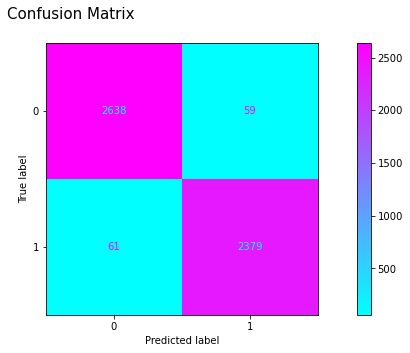

In [18]:
# Build Model with Best Hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train Model
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.3, callbacks=[callback])

# Evaluate Model on Test Data
pred = best_model.predict(X_test)
y_pred = np.argmax(pred, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['NASNetMobile Tuned'] = results

##  EfficientNetV2B0

In [19]:
# Define Tuner
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, EfficientNetV2B0),
    objective='val_accuracy',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times each model is trained
    directory='tuning_results',  
    project_name='hyperparameter_tuning'
)

# Stop early if no improvement in 3 epochs
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Start Hyperparameter Search
tuner.search(X_train, y_train, epochs=10, validation_split=0.3, callbacks=[callback])

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: units={best_hps.get('units')}, dropout={best_hps.get('dropout')}, "
      f"optimizer={best_hps.get('optimizer')}, learning rate={best_hps.get('lr')}")

Reloading Tuner from tuning_results\hyperparameter_tuning\tuner0.json
Best Hyperparameters: units=64, dropout=0.2, optimizer=adam, learning rate=0.001


Epoch 1/20
450/450 [==============================] - 269s 586ms/step - loss: 0.1150 - accuracy: 0.9567 - val_loss: 0.0249 - val_accuracy: 0.9929
Epoch 2/20
450/450 [==============================] - 265s 589ms/step - loss: 0.0332 - accuracy: 0.9902 - val_loss: 0.0143 - val_accuracy: 0.9961
Epoch 3/20
450/450 [==============================] - 263s 585ms/step - loss: 0.0240 - accuracy: 0.9926 - val_loss: 0.0074 - val_accuracy: 0.9982
Epoch 4/20
450/450 [==============================] - 264s 586ms/step - loss: 0.0152 - accuracy: 0.9950 - val_loss: 0.0053 - val_accuracy: 0.9982
Epoch 5/20
450/450 [==============================] - 267s 593ms/step - loss: 0.0140 - accuracy: 0.9960 - val_loss: 0.0052 - val_accuracy: 0.9984
Epoch 6/20
450/450 [==============================] - 265s 588ms/step - loss: 0.0137 - accuracy: 0.9952 - val_loss: 0.0048 - val_accuracy: 0.9982
Epoch 7/20
450/450 [==============================] - 267s 593ms/step - loss: 0.0118 - accuracy: 0.9960 - val_loss: 0.0062 -

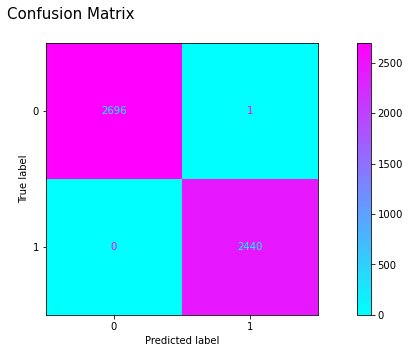

In [20]:
# Build Model with Best Hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train Model
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.3, callbacks=[callback])

# Evaluate Model on Test Data
pred = best_model.predict(X_test)
y_pred = np.argmax(pred, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['EfficientNetV2B0 Tuned'] = results

## DenseNet121

In [21]:
# Define Tuner
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, DenseNet121),
    objective='val_accuracy',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times each model is trained
    directory='tuning_results',  
    project_name='hyperparameter_tuning'
)

# Stop early if no improvement in 3 epochs
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Start Hyperparameter Search
tuner.search(X_train, y_train, epochs=10, validation_split=0.3, callbacks=[callback])

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: units={best_hps.get('units')}, dropout={best_hps.get('dropout')}, "
      f"optimizer={best_hps.get('optimizer')}, learning rate={best_hps.get('lr')}")

Reloading Tuner from tuning_results\hyperparameter_tuning\tuner0.json
Best Hyperparameters: units=64, dropout=0.2, optimizer=adam, learning rate=0.001


Epoch 1/20
450/450 [==============================] - 756s 2s/step - loss: 0.3611 - accuracy: 0.8438 - val_loss: 0.1723 - val_accuracy: 0.9405
Epoch 2/20
450/450 [==============================] - 746s 2s/step - loss: 0.1754 - accuracy: 0.9356 - val_loss: 0.1322 - val_accuracy: 0.9568
Epoch 3/20
450/450 [==============================] - 748s 2s/step - loss: 0.1253 - accuracy: 0.9557 - val_loss: 0.1024 - val_accuracy: 0.9603
Epoch 4/20
450/450 [==============================] - 745s 2s/step - loss: 0.0914 - accuracy: 0.9683 - val_loss: 0.0687 - val_accuracy: 0.9763
Epoch 5/20
450/450 [==============================] - 744s 2s/step - loss: 0.0753 - accuracy: 0.9736 - val_loss: 0.0542 - val_accuracy: 0.9828
Epoch 6/20
450/450 [==============================] - 742s 2s/step - loss: 0.0682 - accuracy: 0.9760 - val_loss: 0.0436 - val_accuracy: 0.9891
Epoch 7/20
450/450 [==============================] - 742s 2s/step - loss: 0.0545 - accuracy: 0.9809 - val_loss: 0.0354 - val_accuracy: 0.9872

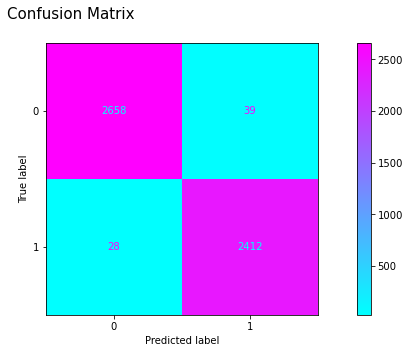

In [22]:
# Build Model with Best Hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train Model
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.3, callbacks=[callback])

# Evaluate Model on Test Data
pred = best_model.predict(X_test)
y_pred = np.argmax(pred, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['DenseNet121 Tuned'] = results

##  ResNet50

In [23]:
# Define Tuner
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, ResNet50),
    objective='val_accuracy',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times each model is trained
    directory='tuning_results',  
    project_name='hyperparameter_tuning'
)

# Stop early if no improvement in 3 epochs
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Start Hyperparameter Search
tuner.search(X_train, y_train, epochs=10, validation_split=0.3, callbacks=[callback])

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: units={best_hps.get('units')}, dropout={best_hps.get('dropout')}, "
      f"optimizer={best_hps.get('optimizer')}, learning rate={best_hps.get('lr')}")

Reloading Tuner from tuning_results\hyperparameter_tuning\tuner0.json
Best Hyperparameters: units=64, dropout=0.2, optimizer=adam, learning rate=0.001


Epoch 1/20
450/450 [==============================] - 681s 2s/step - loss: 0.1214 - accuracy: 0.9539 - val_loss: 0.0247 - val_accuracy: 0.9929
Epoch 2/20
450/450 [==============================] - 683s 2s/step - loss: 0.0317 - accuracy: 0.9896 - val_loss: 0.0219 - val_accuracy: 0.9927
Epoch 3/20
450/450 [==============================] - 684s 2s/step - loss: 0.0236 - accuracy: 0.9930 - val_loss: 0.0135 - val_accuracy: 0.9956
Epoch 4/20
450/450 [==============================] - 686s 2s/step - loss: 0.0113 - accuracy: 0.9969 - val_loss: 0.0073 - val_accuracy: 0.9976
Epoch 5/20
450/450 [==============================] - 688s 2s/step - loss: 0.0148 - accuracy: 0.9949 - val_loss: 0.0142 - val_accuracy: 0.9938
Epoch 6/20
450/450 [==============================] - 689s 2s/step - loss: 0.0095 - accuracy: 0.9972 - val_loss: 0.0085 - val_accuracy: 0.9977
Epoch 7/20
161/161 [==============================] - 174s 1s/step

--------------- Evaluation ---------------
Accuracy: 0.998
Precision: 0.99

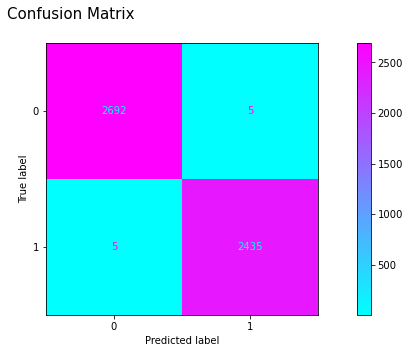

In [24]:
# Build Model with Best Hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train Model
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.3, callbacks=[callback])

# Evaluate Model on Test Data
pred = best_model.predict(X_test)
y_pred = np.argmax(pred, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['ResNet50 Tuned'] = results

## ResNet50V2 

In [25]:
# Define Tuner
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, ResNet50V2),
    objective='val_accuracy',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times each model is trained
    directory='tuning_results',  
    project_name='hyperparameter_tuning'
)

# Stop early if no improvement in 3 epochs
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Start Hyperparameter Search
tuner.search(X_train, y_train, epochs=10, validation_split=0.3, callbacks=[callback])

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: units={best_hps.get('units')}, dropout={best_hps.get('dropout')}, "
      f"optimizer={best_hps.get('optimizer')}, learning rate={best_hps.get('lr')}")

Reloading Tuner from tuning_results\hyperparameter_tuning\tuner0.json
Best Hyperparameters: units=64, dropout=0.2, optimizer=adam, learning rate=0.001


Epoch 1/20
450/450 [==============================] - 547s 1s/step - loss: 2.1608 - accuracy: 0.6296 - val_loss: 0.5922 - val_accuracy: 0.7145
Epoch 2/20
450/450 [==============================] - 543s 1s/step - loss: 0.5925 - accuracy: 0.6742 - val_loss: 0.6523 - val_accuracy: 0.6033
Epoch 3/20
450/450 [==============================] - 545s 1s/step - loss: 0.5376 - accuracy: 0.7238 - val_loss: 0.5155 - val_accuracy: 0.7852
Epoch 4/20
450/450 [==============================] - 546s 1s/step - loss: 0.6941 - accuracy: 0.5304 - val_loss: 0.6883 - val_accuracy: 0.5196
Epoch 5/20
450/450 [==============================] - 545s 1s/step - loss: 0.6847 - accuracy: 0.5259 - val_loss: 0.6876 - val_accuracy: 0.5196
Epoch 6/20
161/161 [==============================] - 136s 841ms/step

--------------- Evaluation ---------------
Accuracy: 0.775
Precision: 0.989
Recall: 0.532
F1 Score: 0.692
ROC AUC: 0.763

Classification Report: 
                              precision    recall  f1-score   suppor

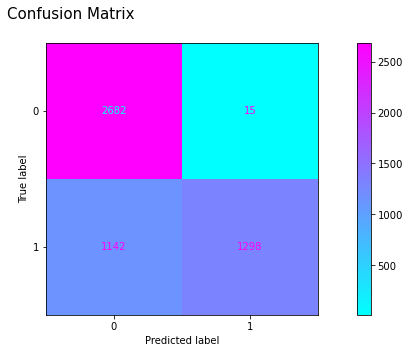

In [26]:
# Build Model with Best Hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train Model
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.3, callbacks=[callback])

# Evaluate Model on Test Data
pred = best_model.predict(X_test)
y_pred = np.argmax(pred, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['ResNet50V2 Tuned'] = results

## InceptionV3

In [27]:
# Define Tuner
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, InceptionV3),
    objective='val_accuracy',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times each model is trained
    directory='tuning_results',  
    project_name='hyperparameter_tuning'
)

# Stop early if no improvement in 3 epochs
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Start Hyperparameter Search
tuner.search(X_train, y_train, epochs=10, validation_split=0.3, callbacks=[callback])

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: units={best_hps.get('units')}, dropout={best_hps.get('dropout')}, "
      f"optimizer={best_hps.get('optimizer')}, learning rate={best_hps.get('lr')}")

Reloading Tuner from tuning_results\hyperparameter_tuning\tuner0.json
Best Hyperparameters: units=64, dropout=0.2, optimizer=adam, learning rate=0.001


Epoch 1/20
450/450 [==============================] - 498s 1s/step - loss: 0.9267 - accuracy: 0.7422 - val_loss: 0.4136 - val_accuracy: 0.8378
Epoch 2/20
450/450 [==============================] - 484s 1s/step - loss: 0.3844 - accuracy: 0.8152 - val_loss: 0.3172 - val_accuracy: 0.8775
Epoch 3/20
450/450 [==============================] - 495s 1s/step - loss: 0.3808 - accuracy: 0.7996 - val_loss: 0.2758 - val_accuracy: 0.8881
Epoch 4/20
450/450 [==============================] - 482s 1s/step - loss: 0.3327 - accuracy: 0.8251 - val_loss: 0.2458 - val_accuracy: 0.9158
Epoch 5/20
450/450 [==============================] - 496s 1s/step - loss: 0.3207 - accuracy: 0.8351 - val_loss: 0.2007 - val_accuracy: 0.9234
Epoch 6/20
450/450 [==============================] - 482s 1s/step - loss: 0.3044 - accuracy: 0.8419 - val_loss: 0.2561 - val_accuracy: 0.9126
Epoch 7/20
450/450 [==============================] - 481s 1s/step - loss: 0.2939 - accuracy: 0.8499 - val_loss: 0.2043 - val_accuracy: 0.9142

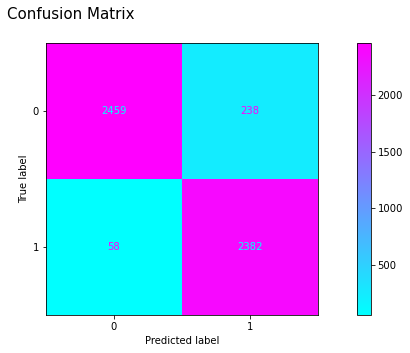

In [28]:
# Build Model with Best Hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train Model
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.3, callbacks=[callback])

# Evaluate Model on Test Data
pred = best_model.predict(X_test)
y_pred = np.argmax(pred, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['InceptionV3 Tuned'] = results

## Xception 

In [29]:
# Define Tuner
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, Xception),
    objective='val_accuracy',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times each model is trained
    directory='tuning_results',  
    project_name='hyperparameter_tuning'
)

# Stop early if no improvement in 3 epochs
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Start Hyperparameter Search
tuner.search(X_train, y_train, epochs=10, validation_split=0.3, callbacks=[callback])

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: units={best_hps.get('units')}, dropout={best_hps.get('dropout')}, "
      f"optimizer={best_hps.get('optimizer')}, learning rate={best_hps.get('lr')}")

Reloading Tuner from tuning_results\hyperparameter_tuning\tuner0.json
Best Hyperparameters: units=64, dropout=0.2, optimizer=adam, learning rate=0.001


Epoch 1/20
450/450 [==============================] - 679s 2s/step - loss: 0.5685 - accuracy: 0.8052 - val_loss: 0.2607 - val_accuracy: 0.8921
Epoch 2/20
450/450 [==============================] - 588s 1s/step - loss: 0.2599 - accuracy: 0.8911 - val_loss: 0.2431 - val_accuracy: 0.9035
Epoch 3/20
450/450 [==============================] - 587s 1s/step - loss: 0.2009 - accuracy: 0.9138 - val_loss: 0.2405 - val_accuracy: 0.8923
Epoch 4/20
450/450 [==============================] - 601s 1s/step - loss: 0.2007 - accuracy: 0.9161 - val_loss: 0.1638 - val_accuracy: 0.9374
Epoch 5/20
450/450 [==============================] - 592s 1s/step - loss: 0.1746 - accuracy: 0.9256 - val_loss: 0.1584 - val_accuracy: 0.9431
Epoch 6/20
450/450 [==============================] - 588s 1s/step - loss: 0.1539 - accuracy: 0.9369 - val_loss: 0.1846 - val_accuracy: 0.9213
Epoch 7/20
450/450 [==============================] - 589s 1s/step - loss: 0.1527 - accuracy: 0.9367 - val_loss: 0.2178 - val_accuracy: 0.9225

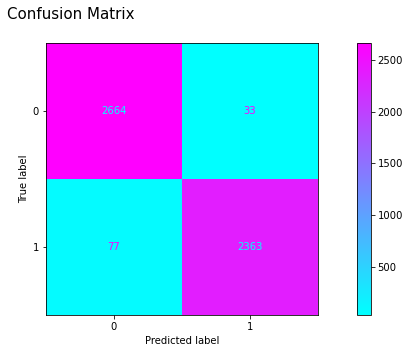

In [30]:
# Build Model with Best Hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train Model
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.3, callbacks=[callback])

# Evaluate Model on Test Data
pred = best_model.predict(X_test)
y_pred = np.argmax(pred, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['Xception Tuned'] = results

## InceptionResNetV2 

In [31]:
# Define Tuner
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, InceptionResNetV2),
    objective='val_accuracy',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times each model is trained
    directory='tuning_results',  
    project_name='hyperparameter_tuning'
)

# Stop early if no improvement in 3 epochs
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Start Hyperparameter Search
tuner.search(X_train, y_train, epochs=10, validation_split=0.3, callbacks=[callback])

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: units={best_hps.get('units')}, dropout={best_hps.get('dropout')}, "
      f"optimizer={best_hps.get('optimizer')}, learning rate={best_hps.get('lr')}")

Reloading Tuner from tuning_results\hyperparameter_tuning\tuner0.json
Best Hyperparameters: units=64, dropout=0.2, optimizer=adam, learning rate=0.001


Epoch 1/20
450/450 [==============================] - 799s 2s/step - loss: 2.6678 - accuracy: 0.5233 - val_loss: 0.6924 - val_accuracy: 0.5196
Epoch 2/20
450/450 [==============================] - 814s 2s/step - loss: 0.7032 - accuracy: 0.5241 - val_loss: 0.6924 - val_accuracy: 0.5196
Epoch 3/20
450/450 [==============================] - 816s 2s/step - loss: 0.6920 - accuracy: 0.5242 - val_loss: 0.6924 - val_accuracy: 0.5196
Epoch 4/20
161/161 [==============================] - 208s 1s/step

--------------- Evaluation ---------------
Accuracy: 0.525
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC: 0.5

Classification Report: 
                              precision    recall  f1-score   support

0 -  Negative (No Pathology)       0.53      1.00      0.69      2697
    1 - Positive (Pathology)       0.00      0.00      0.00      2440

                    accuracy                           0.53      5137
                   macro avg       0.26      0.50      0.34      5137
             

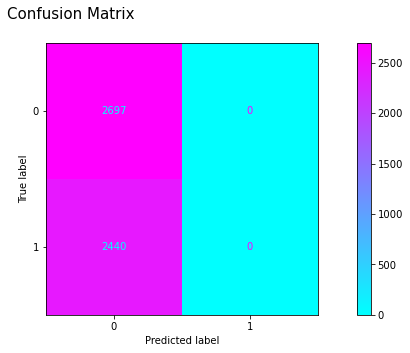

In [32]:
# Build Model with Best Hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train Model
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.3, callbacks=[callback])

# Evaluate Model on Test Data
pred = best_model.predict(X_test)
y_pred = np.argmax(pred, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['InceptionResNetV2 Tuned'] = results

## VGG16 

In [33]:
# Define Tuner
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, VGG16),
    objective='val_accuracy',
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times each model is trained
    directory='tuning_results',  
    project_name='hyperparameter_tuning'
)

# Stop early if no improvement in 3 epochs
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Start Hyperparameter Search
tuner.search(X_train, y_train, epochs=10, validation_split=0.3, callbacks=[callback])

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: units={best_hps.get('units')}, dropout={best_hps.get('dropout')}, "
      f"optimizer={best_hps.get('optimizer')}, learning rate={best_hps.get('lr')}")

Reloading Tuner from tuning_results\hyperparameter_tuning\tuner0.json
Best Hyperparameters: units=64, dropout=0.2, optimizer=adam, learning rate=0.001


Epoch 1/20
450/450 [==============================] - 1292s 3s/step - loss: 0.2386 - accuracy: 0.9272 - val_loss: 0.0413 - val_accuracy: 0.9880
Epoch 2/20
450/450 [==============================] - 2040s 5s/step - loss: 0.0435 - accuracy: 0.9857 - val_loss: 0.0227 - val_accuracy: 0.9938
Epoch 3/20
450/450 [==============================] - 2040s 5s/step - loss: 0.0256 - accuracy: 0.9930 - val_loss: 0.0160 - val_accuracy: 0.9959
Epoch 4/20
450/450 [==============================] - 2040s 5s/step - loss: 0.0146 - accuracy: 0.9953 - val_loss: 0.0098 - val_accuracy: 0.9963
Epoch 5/20
450/450 [==============================] - 2038s 5s/step - loss: 0.0157 - accuracy: 0.9953 - val_loss: 0.0129 - val_accuracy: 0.9961
Epoch 6/20
450/450 [==============================] - 2040s 5s/step - loss: 0.0114 - accuracy: 0.9965 - val_loss: 0.0054 - val_accuracy: 0.9981
Epoch 7/20
450/450 [==============================] - 2038s 5s/step - loss: 0.0106 - accuracy: 0.9970 - val_loss: 0.0076 - val_accuracy:

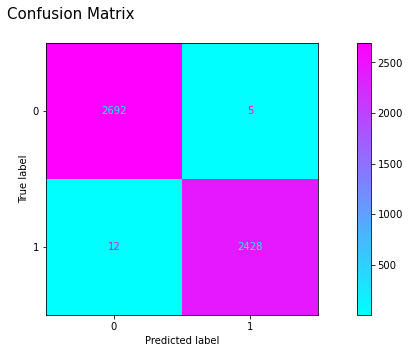

In [34]:
# Build Model with Best Hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train Model
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.3, callbacks=[callback])

# Evaluate Model on Test Data
pred = best_model.predict(X_test)
y_pred = np.argmax(pred, axis=1)

results = evaluate(y_test, y_pred, X_train, y_train)
model_results['VGG16 Tuned'] = results

## Model Results 

In [35]:
model_results.head(10)

,Metrics,MobileNetV3 Small Tuned,MobileNetV3 Large Tuned,NASNetMobile Tuned,EfficientNetV2B0 Tuned,DenseNet121 Tuned,ResNet50 Tuned,ResNet50V2 Tuned,InceptionV3 Tuned,Xception Tuned,InceptionResNetV2 Tuned,VGG16 Tuned
0,Accuracy,0.998637,0.999611,0.976640,0.999805,0.986957,0.998053,0.774771,0.942379,0.978587,0.525015,0.996691
1,Precision,0.999589,0.999590,0.975800,0.999590,0.984088,0.997951,0.988576,0.909160,0.986227,0.000000,0.997945
2,Recall,0.997541,0.999590,0.975000,1.000000,0.988525,0.997951,0.531967,0.976230,0.968443,0.000000,0.995082
3,F1Score,0.998564,0.999590,0.975400,0.999795,0.986301,0.997951,0.691713,0.941502,0.977254,0.000000,0.996511
4,ROC AUC,0.998585,0.999610,0.976562,0.999815,0.987032,0.998048,0.763203,0.943992,0.978103,0.500000,0.996614


In [36]:
model_results.to_csv('../results/tuned_image_model_results.csv', index=True)